# KNN for outliers detection

This notebook attempts to use KNN for outlier detection and automate auto-tuning of the parameters. 

Reference:

1. [KNN for anamoly](https://medium.com/@gabrielpierobon/k-nearest-neighbors-knn-for-anomaly-detection-d9bcc2d4f71a)
    - Github nb: https://github.com/gabrielpierobon/anomaly_detection/blob/main/Chapter%2009%20K-Nearest%20Neighbors%20(KNN)%20for%20Anomaly%20Detection.ipynb
    

This uses the LocalOutlierFactor from [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html):

Unsupervised Outlier Detection using the Local Outlier Factor (LOF).

The anomaly score of each sample is called the Local Outlier Factor. It measures the local deviation of the density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [44]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import pyleoclim as pyleo

# Seed for reproducibility
np.random.seed(1)

## Synthetic dataset
We first start with a synthetic dataset to understand the basics of KNN anomaly detection.

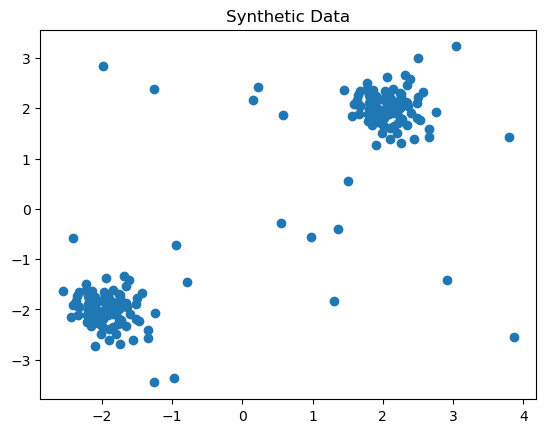

In [3]:
# Generate training data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Combine the two datasets
X = np.r_[X_inliers, X_outliers]

# Plot the data
plt.scatter(X[:, 0], X[:, 1])
plt.title("Synthetic Data")
plt.show()

According to the medium blog post, in the plot below, the blue points are the normal data points whereas the orange points are the detected anomalies.

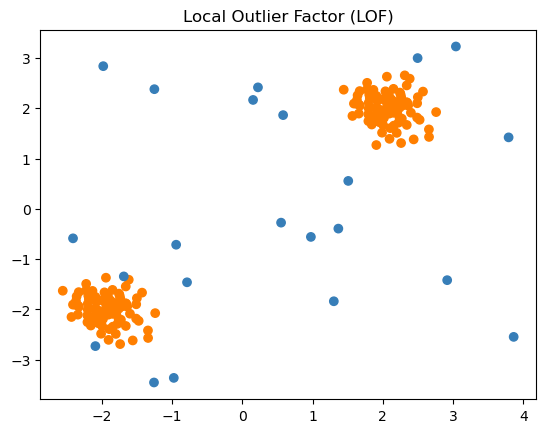

In [4]:
# Fit the model
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)

# Generate colors based on the prediction
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], color=colors[(y_pred + 1) // 2])
plt.title("Local Outlier Factor (LOF)")
plt.show()

fit_predict: Label is 1 for an inlier and -1 for an outlier according to the LOF score and the contamination parameter.

In [5]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

According to the documentation (and visualization), the blue dots are outliers.

## Real-world dataset
Here, we will then be using the "Credit Card Fraud Detection" dataset from [Kaggle](https://www.kaggle.com/datasets/arockiaselciaa/creditcardcsv?select=creditcard.csv). It consists of transactions made by credit cards, where the positive class (frauds)
account for only 0.172% of all transactions.

In [6]:
# Import necessary libraries
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

The dataset contains only numerical input variables which are the result of a PCA transformation.

Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
- Time: contains the seconds elapsed between each transaction and the first transaction in the dataset
- Amount: The transaction amount
- Class: response variable and it takes value 1 in case of fraud and 0 otherwise

In [7]:
# Load the dataset
data = pd.read_csv('creditcard.csv')

# Take a look at the data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


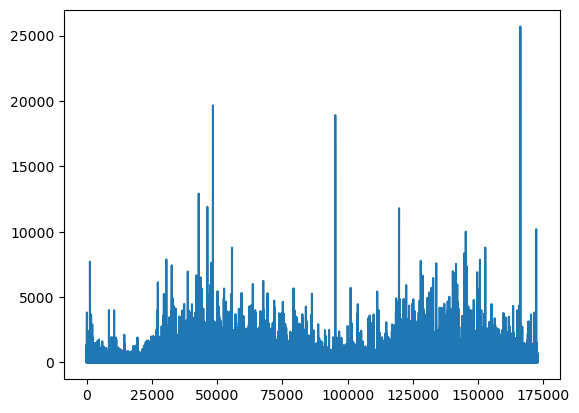

In [8]:
plt.plot(data['Time'],data['Amount'])

### Exploration of the dataset

In [9]:
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### Sample dataset

In [10]:
# Set the fraction of data to sample
fraction = 0.1

# We will use stratified sampling to maintain the ratio of anomalies
stratified_data = data.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=fraction))

# Separate out the features and labels
X_sample = stratified_data.drop('Class', axis=1)
y_sample = stratified_data['Class']

# Standardize the features to have a mean of ~ 0 and a variance of 1
scaler = StandardScaler()
X_std_sample = scaler.fit_transform(X_sample)

In [11]:
X_std_sample

array([[ 1.20863751, -1.04654389,  0.74205814, ...,  0.11650828,
        -0.2573972 , -0.18487818],
       [ 0.13683089,  0.64887673, -0.65738745, ..., -0.0843809 ,
         0.02495967,  1.06854992],
       [-1.8011888 , -4.8451151 ,  2.76579438, ...,  1.15375868,
        -1.31042542, -0.3819042 ],
       ...,
       [ 0.1623034 , -0.97028317,  2.44271448, ...,  2.23407871,
         0.71014489, -0.3819466 ],
       [-0.51128433, -1.14380994, -0.27331668, ...,  0.65985627,
         0.77035956,  3.11521234],
       [-1.24165805, -1.44070589,  2.43022002, ...,  2.99935143,
         2.07469744, -0.37770675]])

### Train model
Finally, after sampling the dataset, we start to train our KNN models. Here, we adopted two kinds of anomalty detection: novelty and outlier.

Novelty trains on only the normal trascations and looks for the "strange" data points and mark it as outlier, while the default outlier trains on the whole transaction and looks for data points that have a substantially lower density than their neighbors

#### Novelty

In [12]:
# Train the model
# Note that this is novelty detection so we only train on normal transactions
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(X_std_sample[y_sample == 0])  # train the model on the normal transactions

# Predict the labels for the entire dataset
y_pred = model.predict(X_std_sample)

# Convert the prediction values to match with 'Class' column in the original dataset
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Print the confusion matrix
print(confusion_matrix(y_sample, y_pred))

[[26918  1514]
 [    9    40]]


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     28432
           1       0.03      0.82      0.05        49

    accuracy                           0.95     28481
   macro avg       0.51      0.88      0.51     28481
weighted avg       1.00      0.95      0.97     28481



#### Outlier

In [14]:
# Train the model and predict the labels for the entire dataset
model = LocalOutlierFactor(n_neighbors=20, novelty=False)
y_pred = model.fit_predict(X_std_sample)

# Convert the prediction values to match with 'Class' column in the original dataset
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Print the confusion matrix
print(confusion_matrix(y_sample, y_pred))

[[26637  1795]
 [   35    14]]


In [15]:
print(classification_report(y_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     28432
           1       0.01      0.29      0.02        49

    accuracy                           0.94     28481
   macro avg       0.50      0.61      0.49     28481
weighted avg       1.00      0.94      0.97     28481



From the results, we could observe that novelty did a better job than outlier, scoring a 0.78 on recall (which we care more in this case) for fraud while outlier only scores a 0.45

Let's try to only use the amount data since this would be closer to what we need to do for paleoclimate timeseries.

In [16]:
X = np.array(data['Amount']).reshape(-1, 1)

model = LocalOutlierFactor(n_neighbors=20, novelty=False)
y_pred = clf.fit_predict(X)

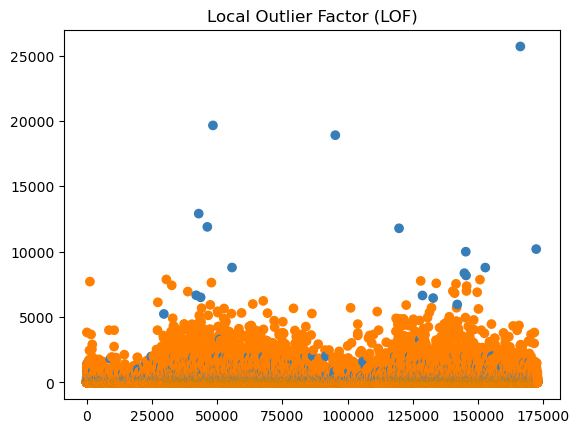

In [17]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(data['Time'], X, color=colors[(y_pred + 1) // 2])
plt.title("Local Outlier Factor (LOF)")
plt.show()

## Explore KNN parameters
Before we get into timeseries data, let's try out how parameters affect the outcome of anomalty detection of KNN

#### Generate nicely defined clusters

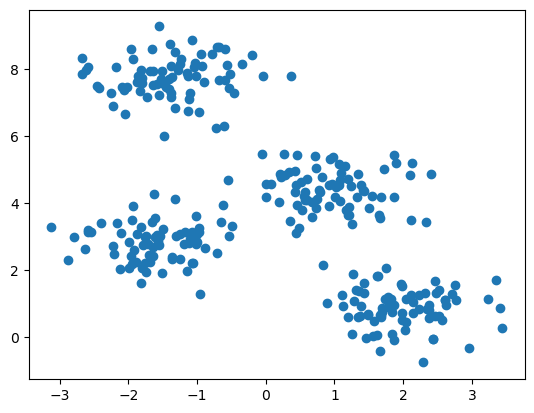

In [18]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

#### Prepare data

In [22]:
# Standardize the features to have a mean of ~ 0 and a variance of 1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#### Train model

In [31]:
# list of parameters being tested
b_list = np.arange(2,11,1)
contam_list = np.arange(0.05, 0.55, 0.05)

In [35]:
# Train the model and record the results
predictions = []
for nb in nb_list:
    for contam in contam_list:
        model = LocalOutlierFactor(n_neighbors=nb, contamination=contam)
        predictions.append([nb, contam, model.fit_predict(X_std)])

#### Plot results

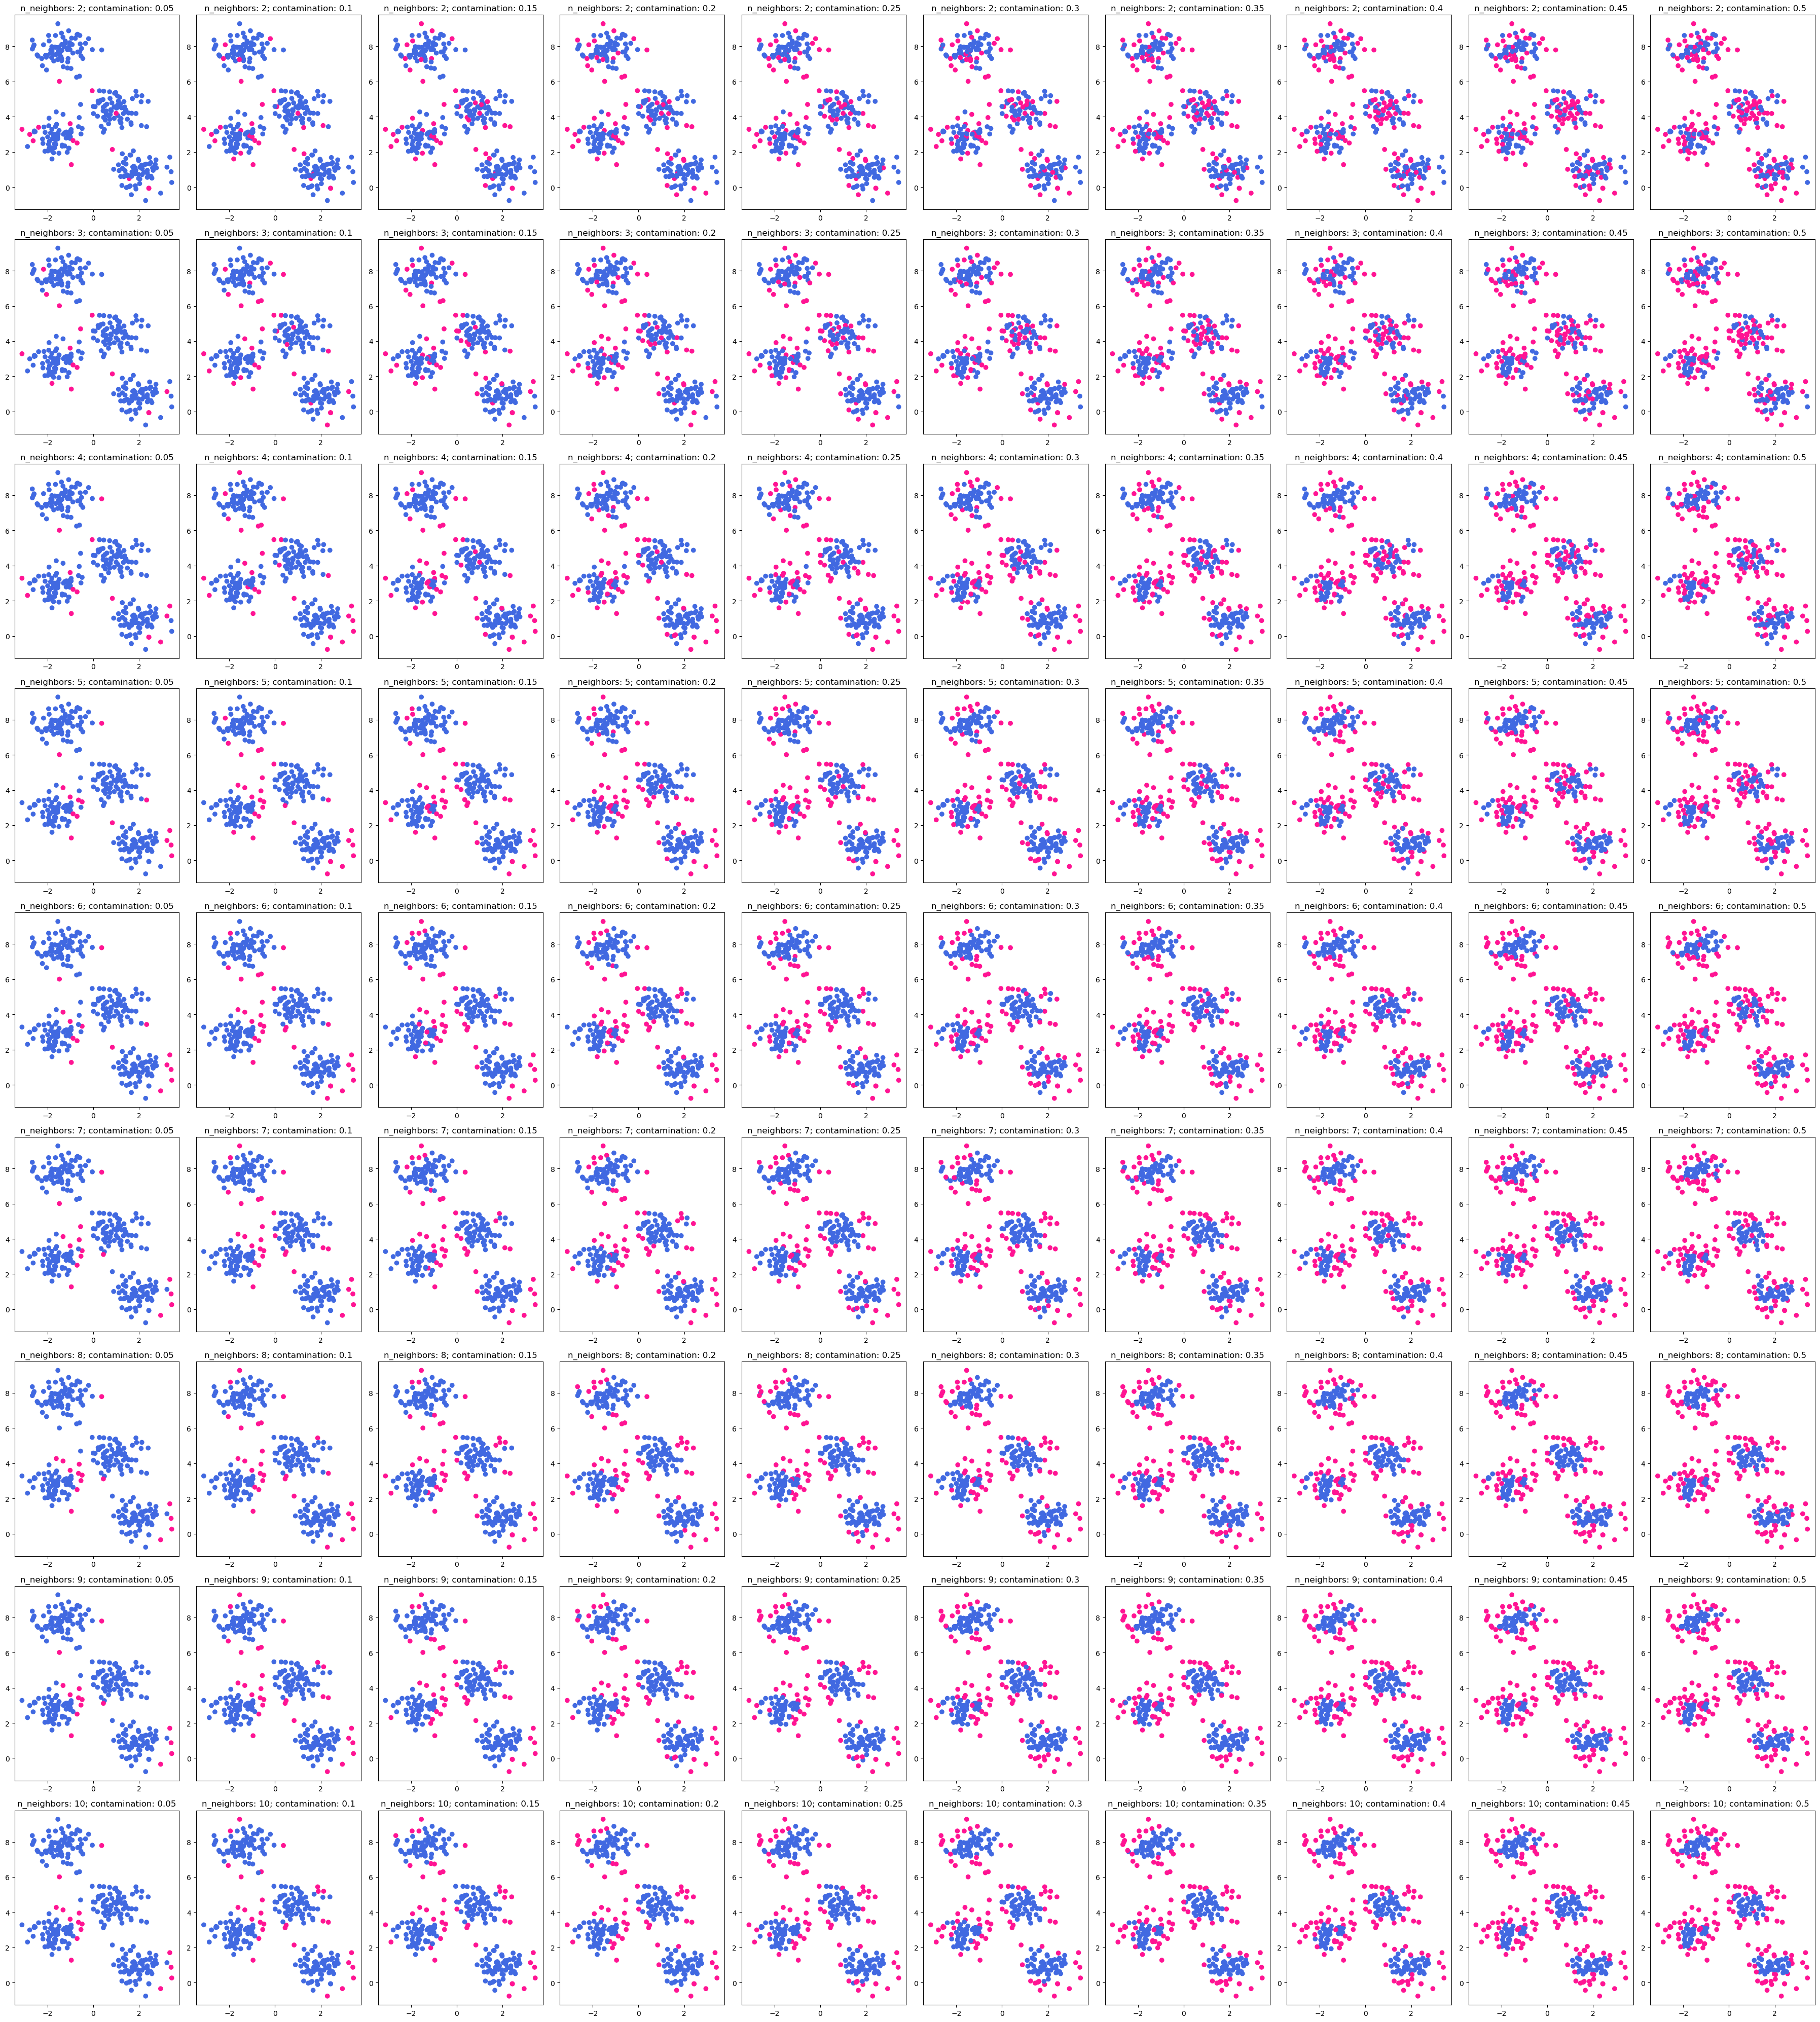

In [42]:
fig, axes = plt.subplots(9, 10, figsize=(36, 40))
for i, y_pred in enumerate(predictions):
    row, col = divmod(i, 10)
    colors = ['deeppink', 'royalblue']
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    ax = axes[row, col]
    
    ax.scatter(X[:, 0], X[:, 1], c=vectorizer((y_pred[2] + 1) // 2))
    ax.set_title('n_neighbors: ' + str(y_pred[0]) + '; contamination: ' + str(y_pred[1])[:4])

# 隐藏多余的子图
for i in range(len(predictions), 9 * 10):
    row, col = divmod(i, 10)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

Wow that's a lot of plots, but we could still observe how parameters affect the outcome by looking at the trend.

(The n_neighbors increases from 2 to 10 when going down and contamination increases from 0.05 to 0.5 when going right)
1. n_neighbors: less sensitive, data points in the same group (outlier/inlier) becomes more gathered when increasing
2. contamination: sensitive, marks more and more less dense points as outliers when increasing

## Timeseries data
And now, we are finally trying to use KNN on timeseries data. Again, let's first try it on synthetic data.

### Noisy Dataset
Let's use a noisy signal with outliers

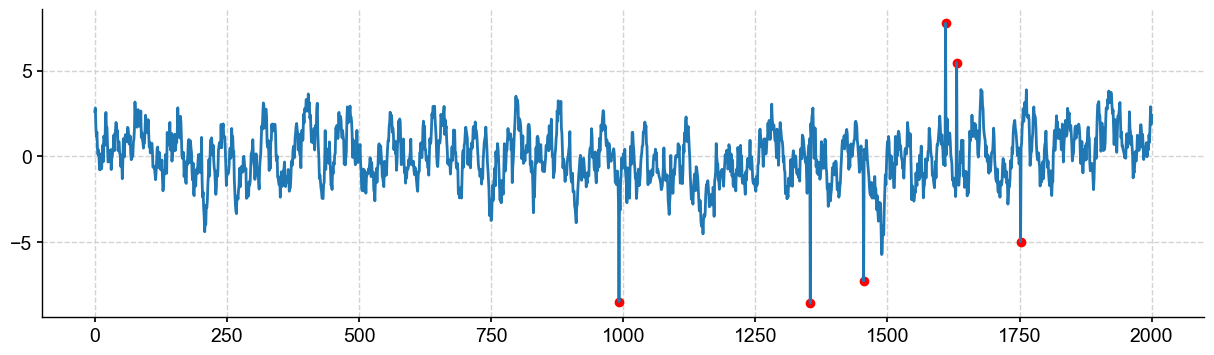

In [45]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise
t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

### (WIP) Silhouette Score method

Next, we're going to try auto-tuning on LOF using on simple blobs. There are two main parameters for [LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html): 
1. n_neighbors: Number of neighbors to use by default for kneighbors queries.
2. contamination: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. When fitting this is used to define the threshold on the scores of the samples.

Let's look at the impact of n_neighbors and contamination using Silhouette Score method:

- Run values of n_neighbors from 2 to 10
- Run values of contamination from (0, 0.5] with a 0.05 increase

Ref: 
- [Automatic Hyperparameter Tuning Method  for Local Outlier Factor, with Applications to Anomaly Detection](https://support.sas.com/content/dam/SAS/support/en/technical-papers/automatic-hyperparameter-tuning-method-for-local-outlier-factor-with-applications-to-anomaly-detection.pdf)


#### Generate nicely defined clusters

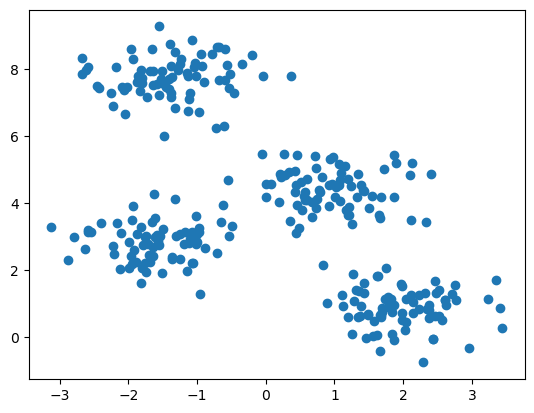

In [12]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

In [13]:
import matplotlib.colors as mcolors

color_cluster = list(mcolors.CSS4_COLORS.keys())
color_cluster.remove('red')
colors=['red']+color_cluster


nb_list = np.arange(2,11,1)
contam_list = np.arange(0.05, 0.55, 0.05)

nbr_clusters=[]
sil_score =[]
nb_matrix=[]
contam_matrix=[]

for nb in nb_list:
    for contam in contam_list:
        nb_matrix.append(nb)
        contam_matrix.append(contam)
        m = LocalOutlierFactor(n_neighbors=nb, contamination=contam, novelty=False)
        m.fit(X)
        nbr_clusters.append(len(np.unique(m.labels_)))
        try:
            sil_score.append(silhouette_score(X, m.labels_))
        except:
            sil_score.append(np.nan)

res = pd.DataFrame({'n_neighbors':nb_matrix,'contamination':contam_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score})
res

AttributeError: 'LocalOutlierFactor' object has no attribute 'labels_'

In [ ]:
# import matplotlib.colors as mcolors

# color_cluster = list(mcolors.CSS4_COLORS.keys())
# color_cluster.remove('red')
# colors=['red']+color_cluster

# nb_list = np.arange(2,11,1)
# contam_list = np.arange(0.05, 0.55, 0.05)

# nb_matrix=[]
# contam_matrix=[]

# real_nb_matrix=[] # actual number of neighbors used
# eff_metric_matrix=[] # the effective metric used for the distance computation.

# for nb in nb_list:
#     for contam in contam_list:
#         nb_matrix.append(nb)
#         contam_matrix.append(contam)
#         m = LocalOutlierFactor(n_neighbors=nb, contamination=contam, novelty=False)
#         m.fit(X)
#         real_nb_matrix.append(m.n_neighbors_)
#         eff_metric_matrix.append(m.effective_metric_)
#         try:
#             sil_score.append(silhouette_score(X, m.labels_))
#         except:
#             sil_score.append(np.nan)

# res = pd.DataFrame({'n_neighbors':nb_matrix,'contamination':contam_matrix,'actual neighbor':real_nb_matrix, 'effective metric':eff_metric_matrix, 
#                     'silhouette score':sil_score})
# res